<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/YouTube_Analytics_Treding%20_Vids_Views_Prediction/YouTube_Views_Predictions_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Enviorment

*Download Dataset From Kaggle*

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datasnaek/youtube")
print("Path to dataset files:", path)

100%|██████████| 55.9M/55.9M [00:00<00:00, 180MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/datasnaek/youtube/versions/24


*Import Libraries*

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

*Setup Enviroment*

In [4]:
# Setup warnings
import warnings
warnings.filterwarnings('ignore')

# Setup logging
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    handlers=[
        logging.FileHandler("app_log.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

*Load Dataset*

In [12]:
# Define PATH
DATA = "/root/.cache/kagglehub/datasets/datasnaek/youtube/versions/24/USvideos.csv"

# Load dataset
df = pd.read_csv(
    DATA,
    on_bad_lines='skip',  # 'skip' to silently drop bad lines
    quoting=1,
    encoding='utf-8'
)

df.head() # Check first rows

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,13.09
3,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,13.09
4,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,13.09


# Define Required Functions

*Load & Prepare Dataset*

In [83]:
def load_and_prepare_data(file_path):
    logger.info("Loading and preparing dataset...")
    try:
        df = pd.read_csv(
            DATA,
            on_bad_lines='skip',
            quoting=1,
            encoding='utf-8')
        # Select features
        df = df[['title', 'tags', 'category_id', 'likes', 'dislikes', 'comment_total', 'views']]
        # Drop dupe and nans
        df = df.dropna().drop_duplicates()

        logger.info(f"Dataset loaded and cleaned. Shape: {df.shape}")
        return df
    except Exception as e:
        logger.error(f"Error loading and preparing dataset: {e}")
        raise

*Preprocessing Data*

In [84]:
def preprocess_data(df, max_length=50, max_words=5000):
    logger.info("Preprocessing data...")
    try:
        # merge title and tags
        texts = df['title'].fillna("") + " " + df['tags'].fillna("")

        # Text tokenization
        tokenizer = Tokenizer(num_words = max_words, oov_token="<OOV>")
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

        # Normalizing numeric values
        scaler = MinMaxScaler()
        views = scaler.fit_transform(df['views'].values.reshape(-1, 1))
        likes = scaler.fit_transform(df['likes'].values.reshape(-1, 1))
        dislikes = scaler.fit_transform(df['dislikes'].values.reshape(-1, 1))
        comment_total = scaler.fit_transform(df['comment_total'].values.reshape(-1, 1))
        category_id = scaler.fit_transform(df['category_id'].values.reshape(-1, 1))

        # Combine features
        X = np.concatenate([padded_sequences, category_id, likes,
                            dislikes, comment_total], axis=1)
        y = views

        # Spliting to X, y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            random_state=42)
        logger.info(f"Preprocessed data. X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        return X_train, X_test, y_train, y_test, tokenizer, scaler, max_length
    except Exception as e:
        logger.error(f"Error in preprocessing: {e}")
        raise

*Build Model*

In [85]:
def build_lstm_model(vocab_size, sequence_length):
    logger.info("Building LSTM model...")
    try:
        model = Sequential([
            Embedding(vocab_size, 64, input_length=sequence_length + 4),
            LSTM(128, return_sequences=False),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model.compile(loss='mse',
                      optimizer='adam',
                      metrics=['mae'])
        logger.info("LSTM model built successfully.")
        return model
    except Exception as e:
        logger.error(f"Error in building LSTM model: {e}")
        raise

*Train Model*

In [86]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=20):
    logger.info("Training model....")
    try:
        # Defin early_stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        # Trian
        history = model.fit(X_train, y_train,
                            batch_size=32,
                            validation_split=0.2,
                            epochs=epochs)
        loss, mae = model.evaluate(X_test, y_test, verbose=0)
        logger.info(f"Test loss: {loss}, Test MAE: {mae}")
        logger.info("Model trained successfully.")
        return history
    except Exception as e:
        logger.error(f"Error training model: {e}")
        raise

*Predict Views*

In [87]:
def predict_views(model, tokenizer, scaler, text, category_id,
                  likes, dislikes, comment_total, max_length):
    logger.info("Predicting views...")
    try:
        # Input preprocessing
        text_seq = tokenizer.texts_to_sequences([text])
        padded_seq = pad_sequences(text_seq, maxlen=max_length, padding='post')
        category_id_scaled = scaler.fit_transform(np.array([[category_id]]))
        likes_scaled = scaler.fit_transform(np.array([[likes]]))
        dislikes_scaled = scaler.fit_transform(np.array([[dislikes]]))
        comment_total_scaled = scaler.fit_transform(np.array([[comment_total]]))
        input_data = np.concatenate([padded_seq, category_id_scaled, likes_scaled, dislikes_scaled, comment_total_scaled], axis=1)

        # Prediction
        prediction = model.predict(input_data, verbose=0)
        if prediction.ndim > 2:
            prediction = prediction.reshape(prediction.shape[0], -1)
        predicted_views = scaler.inverse_transform(prediction)[0][0]
        logger.info(f"Predicted views: {predicted_views}")
        return predicted_views
    except Exception as e:
        logger.error(f"Error predicting views: {e}")
        raise

*Plot Loss*

In [88]:
def plot_training_history(history):
    logger.info("Plotting training history...")
    try:
        # Plot loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot MAE
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()
        plt.close()
        logger.info("Training history plotted and saved as training_history.png")
    except Exception as e:
        logger.error(f"Error plotting training history: {e}")
        raise

# Run Functions

In [89]:
def main():
    logger.info("Starting YT views predictions project...")

    # Load data
    df = load_and_prepare_data(DATA)
    # Preprocessing
    X_train, X_test, y_train, y_test, tokenizer, scaler, max_length = preprocess_data(df)
    # Creat model
    vocab_size = min(5000, len(tokenizer.word_index) + 1)
    model = build_lstm_model(vocab_size, max_length)
    print("\n ---- SUMMARY ---- \n")
    model.summary()
    # Train model
    print("\n ---- TRAINING ---- \n")
    history = train_model(model, X_train, y_train, X_test, y_test)
    # Plots
    print("\n ---- PLOTTING ---- \n")
    plot_training_history(history)

    # Prediction sample
    sample_text = "Amazing AI tutorial video | ai, technology, tutorial"
    sample_category_id = 28
    sample_likes = 150
    sample_dislikes = 10
    sample_comment_total = 30
    predicted_views = predict_views(model, tokenizer,
                                    scaler, sample_text,
                                    sample_category_id,
                                    sample_likes, sample_dislikes,
                                    sample_comment_total, max_length)

    # Save model
    model.save("yt_views_model.h5")
    logger.info("Model save as yt_views_model.h5")


 ---- SUMMARY ---- 



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


 ---- TRAINING ---- 

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 0.0377 - mae: 0.1025 - val_loss: 0.0038 - val_mae: 0.0228
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.0030 - mae: 0.0218 - val_loss: 0.0037 - val_mae: 0.0212
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - loss: 0.0028 - mae: 0.0218 - val_loss: 0.0035 - val_mae: 0.0205
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.0036 - mae: 0.0244 - val_loss: 0.0035 - val_mae: 0.0204
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0028 - mae: 0.0229 - val_loss: 0.0034 - val_mae: 0.0207
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.0031 - mae: 0.0231 - val_loss: 0.0034 - val_mae: 0.0206
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0034 - mae: 0.0239 - val_loss: 0.0034 - val_mae: 0.0207
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0031 - mae: 0.0241 - val_loss: 0.0033 - val_mae: 0.0211
Epoch 9/20
160/16

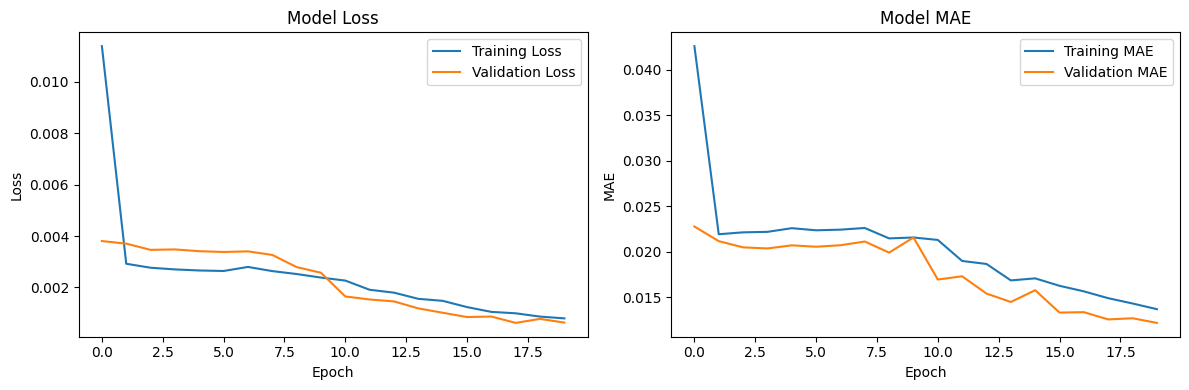

In [90]:
# Run fun
main()